In [171]:
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import missingno as msno
from sklearn.metrics import roc_auc_score
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
AzBio_Merged_all_raw=pd.read_excel(r"/Users/williambray/Data/AZBio_All_CI_Merged_keep_cols_imputed_(1).xlsx")
AzBio_Merged_all_df=prepare_dataset(AzBio_Merged_all_raw)

AUC: 0.8279172055342718


In [20]:
AzBio_Merged_all_df.to_excel('Bilateral_check.xlsx', index=True)

In [155]:
print(AzBio_Merged_all_df['Stage'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 980 entries, 0 to 979
Series name: Stage
Non-Null Count  Dtype
--------------  -----
980 non-null    int64
dtypes: int64(1)
memory usage: 7.8 KB
None


<Axes: >

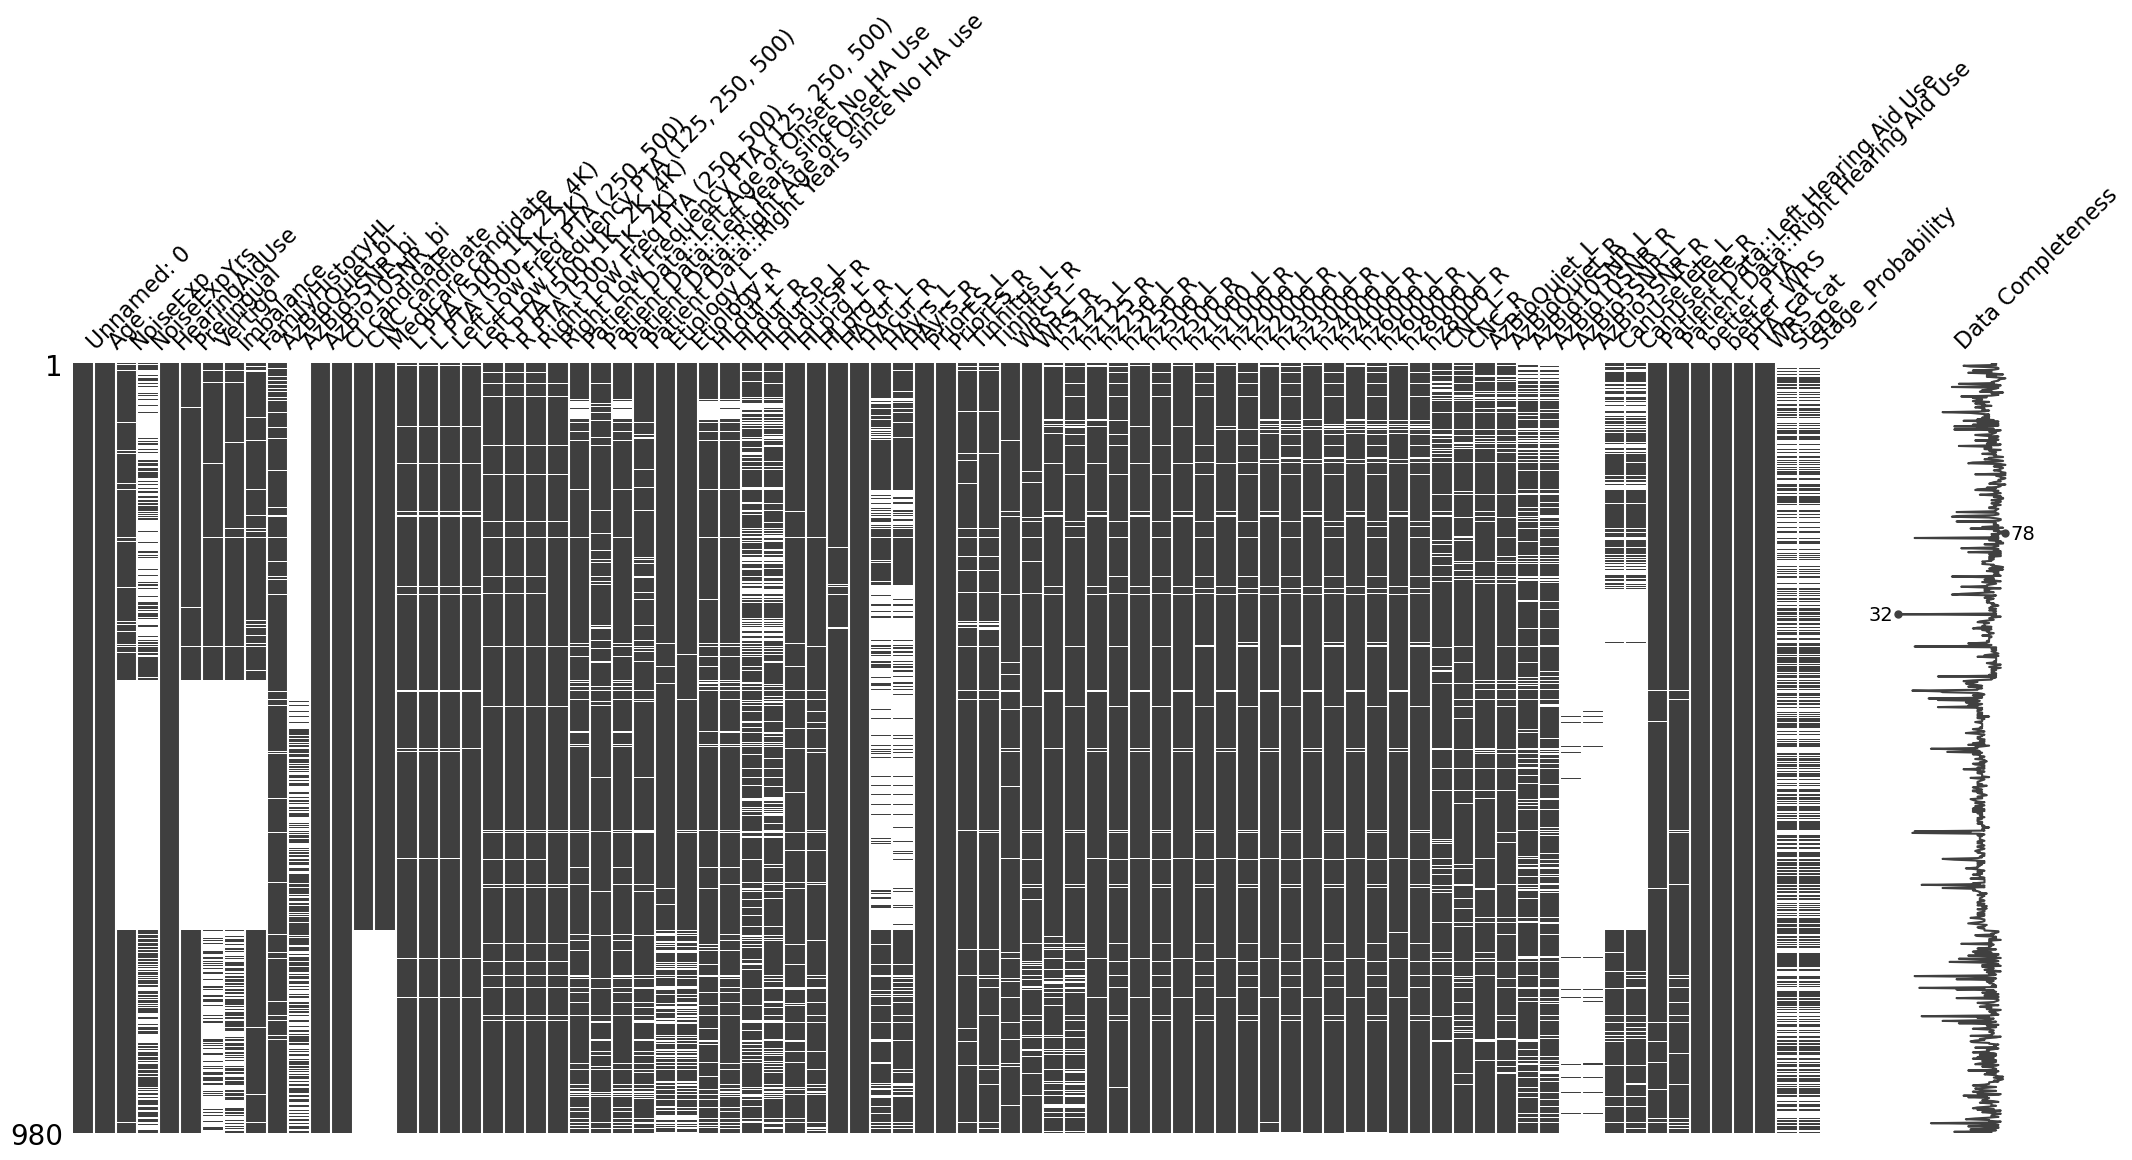

In [169]:
msno.matrix(AzBio_Merged_all_df, labels=True)

In [170]:
def prepare_dataset(df):
    df=better_val(df)
    df=categorize(df)
    df=CI_cand(df)
    #df=PTA4Kfix(df)
    #df=AzBio_simple_stages(df)
    df=AzBio_complex_stages(df)
    df=prob_col(df)
    df=ROC(df)
    return df

In [70]:
def CI_cand(df):
    used_col=['better_WRS','better_PTA']
    df = df.dropna(subset=used_col, how='any')
    Azcol=['AzBioQuiet_bi','AzBio10SNR_bi']
    df=df.dropna(subset=Azcol, how='all')
    df.loc[(df['AzBio10SNR_bi']<=60)|(df['AzBioQuiet_bi']<= 60),'CI candidate']=1
    df.loc[(df['AzBio10SNR_bi']>60)&(df['AzBioQuiet_bi'] > 60),'CI candidate']=0
    return df


In [71]:
def better_val(df):
    df['better_PTA'] = df[['L PTA (500, 1K, 2K, 4K)', 'R PTA (500, 1K, 2K, 4K)']].min(axis=1)
    df['better_WRS'] = df[['WRS_L','WRS_R']].max(axis=1)
    return df

In [161]:
def categorize(df):
#     conditions_pta = [
#           (df['better_PTA'] >= -5) & (df['better_PTA'] <= 40),
#           (df['better_PTA'] >= 41) & (df['better_PTA'] <= 60),
#           (df['better_PTA'] >= 61) & (df['better_PTA'] <= 80),
#           (df['better_PTA'] >= 81)
#       ]
#     categories_pta = [0, 1, 2, 3]
    conditions_pta = [
           (df['better_PTA'] >= -5) & (df['better_PTA'] <= 30),
           (df['better_PTA'] >= 31) & (df['better_PTA'] <= 45),
           (df['better_PTA'] >= 46) & (df['better_PTA'] <= 60),
           (df['better_PTA'] >= 61) & (df['better_PTA'] <= 75),
           (df['better_PTA'] >= 76) & (df['better_PTA'] <= 90),
           (df['better_PTA'] >= 91) & (df['better_PTA'] <= 105),
           (df['better_PTA'] >= 106)
       ]
    categories_pta=[0,1,2,3,4,5,6]
    df['PTA_cat'] = np.select(conditions_pta, categories_pta, default=np.nan)

#     conditions_wrs = [
#           (df['better_WRS'] >= 66) & (df['better_WRS'] <= 100),
#           (df['better_WRS'] >= 46) & (df['better_WRS'] <= 65),
#           (df['better_WRS'] >= 26) & (df['better_WRS'] <= 45),
#           (df['better_WRS'] >= 0) & (df['better_WRS'] <= 25)
#     ]
#     categories_wrs = [0, 1, 2, 3]
    conditions_wrs = [
            (df['better_WRS'] >= 91) & (df['better_WRS'] <= 100),
            (df['better_WRS'] >= 81) & (df['better_WRS'] <= 90),
            (df['better_WRS'] >= 71) & (df['better_WRS'] <= 80),
            (df['better_WRS'] >= 61) & (df['better_WRS'] <= 70),
            (df['better_WRS'] >= 51) & (df['better_WRS'] <= 60),
            (df['better_WRS'] >= 41) & (df['better_WRS'] <= 50),
            (df['better_WRS'] >= 31) & (df['better_WRS'] <= 40),
            (df['better_WRS'] >= 21) & (df['better_WRS'] <= 30),
            (df['better_WRS'] >= 11) & (df['better_WRS'] <= 20),
            (df['better_WRS'] >= 0) & (df['better_WRS'] <= 10),
        ]
    categories_wrs = [0,1,2,3,4,5,6,7,8,9]
    df['WRS_cat'] = np.select(conditions_wrs, categories_wrs, default=np.nan)
    return df

In [104]:
def conj_consol(df):
    row='WRS_cat'
    column='PTA_cat'
    total_counts = df.groupby([row, column]).size().reset_index(name='Total Count')
    candidate_counts = df[df['CI candidate'] == 1].groupby([row, column]).size().reset_index(name='Candidate Count')
    merged_counts = pd.merge(total_counts, candidate_counts, on=[row, column], how='left')
    merged_counts['Candidate Count'] = merged_counts['Candidate Count'].fillna(0)
    merged_counts['Percentage'] = (merged_counts['Candidate Count'] / merged_counts['Total Count']) * 100
    merged_counts['Candidates / Total'] = merged_counts['Candidate Count'].astype(int).astype(str) + " / " + merged_counts['Total Count'].astype(int).astype(str)
    result_table = merged_counts.pivot(index=row, columns=column, values='Candidates / Total')
    row_sums = merged_counts.groupby(row)[['Candidate Count', 'Total Count']].sum().astype(int)
    row_sums['Candidates / Total'] = row_sums['Candidate Count'].astype(str) + " / " + row_sums['Total Count'].astype(str)
    col_sums = merged_counts.groupby(column)[['Candidate Count', 'Total Count']].sum().astype(int)
    col_sums['Candidates / Total'] = col_sums['Candidate Count'].astype(str) + " / " + col_sums['Total Count'].astype(str)
    result_table['Row Total'] = row_sums['Candidates / Total']
    col_total = pd.DataFrame(col_sums['Candidates / Total']).T
    col_total.index = ['Column Total']
    result_table = pd.concat([result_table, col_total])
    print(result_table)
conj_consol(AzBio_Merged_all_df)

PTA_cat          0.0     1.0        2.0        3.0        4.0      5.0  \
0.0           2 / 26  2 / 13     2 / 11      1 / 2        NaN      NaN   
1.0            0 / 8   1 / 5     3 / 14      4 / 8      3 / 3    1 / 1   
2.0            0 / 2   2 / 5    13 / 23    22 / 34      4 / 4    1 / 1   
3.0            0 / 1   0 / 4    18 / 34    21 / 26      6 / 6    2 / 2   
4.0              NaN   2 / 5    26 / 42    34 / 49    20 / 22    3 / 3   
5.0              NaN   1 / 2    13 / 16    49 / 57    23 / 27    5 / 5   
6.0              NaN     NaN    16 / 18    64 / 74    29 / 30    5 / 5   
7.0              NaN     NaN    13 / 13    44 / 50    40 / 43  14 / 15   
8.0              NaN   1 / 1    12 / 12    42 / 46    40 / 41  23 / 24   
9.0            0 / 1     NaN      4 / 4    26 / 27    37 / 37  30 / 33   
Column Total  2 / 38  9 / 35  120 / 187  307 / 373  202 / 213  84 / 89   

PTA_cat           6.0  Row Total  
0.0               NaN     7 / 52  
1.0               NaN    12 / 39  
2.0   

In [149]:
def conj_consol_percent(df):
    row = 'WRS_cat'
    column = 'PTA_cat'
    total_counts = df.groupby([row, column]).size().reset_index(name='Total Count')
    candidate_counts = df[df['CI candidate'] == 1].groupby([row, column]).size().reset_index(name='Candidate Count')
    merged_counts = pd.merge(total_counts, candidate_counts, on=[row, column], how='left')
    merged_counts['Candidate Count'] = merged_counts['Candidate Count'].fillna(0)
    merged_counts['Percentage'] = (merged_counts['Candidate Count'] / merged_counts['Total Count']) * 100
    merged_counts['Percentage'] = merged_counts['Percentage'].round(0).astype(int)
    merged_counts['Candidates / Total'] = (
        merged_counts['Candidate Count'].astype(int).astype(str) + " / " +
        merged_counts['Total Count'].astype(int).astype(str) + 
        " (" + merged_counts['Percentage'].astype(str) + "%)"
    )
    result_table = merged_counts.pivot(index=row, columns=column, values='Candidates / Total')
    row_sums = merged_counts.groupby(row)[['Candidate Count', 'Total Count']].sum().astype(int)
    row_sums['Percentage'] = (row_sums['Candidate Count'] / row_sums['Total Count']) * 100
    row_sums['Percentage'] = row_sums['Percentage'].round(0).astype(int)
    row_sums['Candidates / Total'] = (
        row_sums['Candidate Count'].astype(str) + " / " + 
        row_sums['Total Count'].astype(str) + 
        " (" + row_sums['Percentage'].astype(str) + "%)"
    )
    col_sums = merged_counts.groupby(column)[['Candidate Count', 'Total Count']].sum().astype(int)
    col_sums['Percentage'] = (col_sums['Candidate Count'] / col_sums['Total Count']) * 100
    col_sums['Percentage'] = col_sums['Percentage'].round(0).astype(int)
    col_sums['Candidates / Total'] = (
        col_sums['Candidate Count'].astype(str) + " / " + 
        col_sums['Total Count'].astype(str) + 
        " (" + col_sums['Percentage'].astype(str) + "%)"
    )
    result_table['Row Total'] = row_sums['Candidates / Total']
    col_total = pd.DataFrame(col_sums['Candidates / Total']).T
    col_total.index = ['Column Total']
    result_table = pd.concat([result_table, col_total])
    
    print(result_table)
    result_table.to_excel('10%AzBioCC.xlsx')
conj_consol_percent(AzBio_Merged_all_df)

PTA_cat                0.0              1.0              2.0              3.0  \
0.0           6 / 50 (12%)    28 / 76 (37%)    36 / 55 (65%)     7 / 7 (100%)   
1.0            1 / 5 (20%)    44 / 73 (60%)   98 / 119 (82%)    25 / 28 (89%)   
2.0             0 / 1 (0%)    31 / 33 (94%)  133 / 153 (87%)    61 / 64 (95%)   
3.0            1 / 2 (50%)   20 / 20 (100%)  117 / 125 (94%)  158 / 169 (93%)   
Column Total  8 / 58 (14%)  123 / 202 (61%)  384 / 452 (85%)  251 / 268 (94%)   

PTA_cat             Row Total  
0.0            77 / 188 (41%)  
1.0           168 / 225 (75%)  
2.0           225 / 251 (90%)  
3.0           296 / 316 (94%)  
Column Total              NaN  


In [66]:
def PTA4Kfix(df):
#     df['PTA (500, 1K, 2K, 4K)'] = df[['hz500', 'hz1000', 'hz2000', 'hz4000']].mean(axis=1)
#     df = df[df['PTA (500, 1K, 2K, 4K)'] >= 15]
    hz_columns = ['hz125_L', 'hz250_L', 'hz500_L', 'hz1000_L', 'hz2000_L', 'hz3000_L', 'hz4000_L', 'hz6000_L', 'hz8000_L']
    df = df[~(df[hz_columns] < 20).all(axis=1)]
    hz_columns = ['hz125_R', 'hz250_R', 'hz500_R', 'hz1000_R', 'hz2000_R', 'hz3000_R', 'hz4000_R', 'hz6000_R', 'hz8000_R']
    df = df[~(df[hz_columns] < 20).all(axis=1)]
    df['L PTA (500, 1K, 2K, 4K)'] = df[['hz500_L', 'hz1000_L', 'hz2000_L', 'hz4000_L']].mean(axis=1)
    df['R PTA (500, 1K, 2K, 4K)'] = df[['hz500_R', 'hz1000_R', 'hz2000_R', 'hz4000_R']].mean(axis=1)
    return df

In [148]:
data = {
    'stage': [1,2,3,4,5,6],
    'predicted_probability': [0,17,47,62,83, 97]
}
df = pd.DataFrame(data)

# Calculate the mean predicted probability for each stage
stage_means = df.groupby('stage')['predicted_probability'].mean().reset_index()

# Calculate the differences between adjacent stages
stage_means['difference'] = stage_means['predicted_probability'].diff().abs()

# Remove NaN from the first row (since there's no difference for the first stage)
stage_means = stage_means.dropna()

# Calculate the isometry ratio (largest difference / smallest difference)
isometry_ratio = stage_means['difference'].max() / stage_means['difference'].min()

# Output the results
print("Isometry ratio:", isometry_ratio)
print(stage_means)

Isometry ratio: 2.142857142857143
   stage  predicted_probability  difference
1      2                   17.0        17.0
2      3                   47.0        30.0
3      4                   62.0        15.0
4      5                   83.0        21.0
5      6                   97.0        14.0


In [86]:
AzBio_Merged_all_df['Age'].std()

15.353758252293915

In [102]:
combined_values = pd.concat([AzBio_Merged_all_df['HLprg_L'], AzBio_Merged_all_df['HLprg_R']])
percentages = combined_values.value_counts(normalize=True) *100
print(percentages)

Progressive / Gradual    49.066667
Gradual                  37.546667
Sudden                   12.106667
Fluctuating               0.640000
Mixed                     0.320000
Unknown                   0.320000
Name: proportion, dtype: float64


In [135]:
def AzBio_simple_stages(df):
    stages = []
    for index, row in df.iterrows():
        PTA_cat = row['PTA_cat']
        WRS_cat = row['WRS_cat']
    
    # Stage 0
        if PTA_cat == 0 and WRS_cat == 0:
            stages.append(0)
    # Stage 1
        elif (PTA_cat == 1 and WRS_cat == 0) or (PTA_cat == 0 and WRS_cat == 1):
            stages.append(1)
    # Stage 2
        elif (PTA_cat == 0 and WRS_cat in [2, 3]) or (PTA_cat == 1 and WRS_cat == 1) or (PTA_cat == 2 and WRS_cat == 0):
            stages.append(2)
    # Stage 3
        elif (PTA_cat == 1 and WRS_cat in [2, 3]) or (PTA_cat == 2 and WRS_cat in [1, 2, 3]) or (PTA_cat == 3):
            stages.append(3)
        else:
            stages.append(None)
    df['Stage'] = stages
    return df

In [165]:
def AzBio_complex_stages(df):
    stages = []
    for index, row in df.iterrows():
        PTA_cat = row['PTA_cat']
        WRS_cat = row['WRS_cat']
    
    # Stage 0
        if PTA_cat == 0:
            stages.append(0)
    # Stage 1
        elif (PTA_cat == 1 and WRS_cat in [0,1,2,3,4]) or (PTA_cat == 2 and WRS_cat in [0,1]):
            stages.append(1)
    # Stage 2
        elif (PTA_cat == 1 and WRS_cat==5) or (PTA_cat == 2 and WRS_cat in [2,3,4]) or (PTA_cat == 3 and WRS_cat in [0,1,2]):
            stages.append(2)
    # Stage 3
        elif (PTA_cat == 2 and WRS_cat in [5,6]) or (PTA_cat == 3 and WRS_cat in [3,4,5,6]):
            stages.append(3)
        elif (PTA_cat == 1 and WRS_cat==8) or (PTA_cat == 2 and WRS_cat in [7,8,9]) or (PTA_cat == 3 and WRS_cat in [7,8,9])or (PTA_cat in [4,5,6]):
            stages.append(4)
        else:
            stages.append(None)
    df['Stage'] = stages
    return df

In [150]:
def prob_col(df):
    stage_probabilities = df.groupby('Stage')['CI candidate'].mean().reset_index(name='Stage_Probability')
    df = pd.merge(df, stage_probabilities, on='Stage', how='left')
    return df

In [159]:
def ROC(df):
    true_labels = df['CI candidate']
    predicted_probs = df['Stage_Probability']
    auc = roc_auc_score(true_labels, predicted_probs)
    print(f"AUC: {auc}")
    return df